In [440]:
import serial
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import statistics as stats
from datetime import datetime
import scipy.optimize as optomize
import math

def remonsum(dataframe, xvalues, yvalues):
    dataframe['xshifted'] = dataframe[xvalues].shift(periods = 1, fill_value = 0)
    dataframe['widths'] = np.subtract(dataframe[xvalues], dataframe['xshifted'])
    dataframe['areas'] = np.multiply(dataframe[yvalues], dataframe['widths'])
    return(sum(dataframe['areas']))

In [350]:
path = Path("/Users/christiannorman/Documents/Crus Center/Scholar/FJH/data/Oct24_23_flash1")
data = pd.read_csv(path, skiprows = 3)
data = data.drop('Unnamed: 0', axis = 1)

In [351]:
data

,Time,Current
0,0.024,2.455406
1,0.203,11.731984
2,0.382,12.277665
3,0.561,16.643114
4,0.740,11.186303
...,...,...
27753,4999.407,123.050921
27754,4999.586,114.865705
27755,4999.766,127.416370
27756,4999.945,119.776835


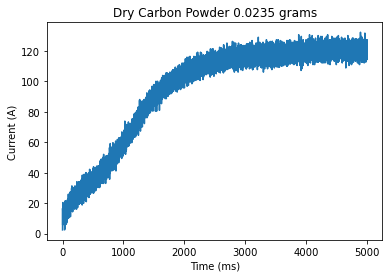

In [550]:
data.plot('Time', 'Current', legend = None)
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.title("Dry Carbon Powder 0.0235 grams")
plt.show()

In [46]:
def logistic(x, x0, k,l):
    value = l/(1+np.exp(-k *np.subtract(x,x0)))
    return value
xvalues = np.arange(0, 5000, .5)

In [48]:
popt, pcov = optomize.curve_fit(logistic, data['Time'], data['Current'], p0 = (1000,1, 120))

In [276]:
popt


array([9.78536083e+02, 1.92960758e-03, 1.19692614e+02])

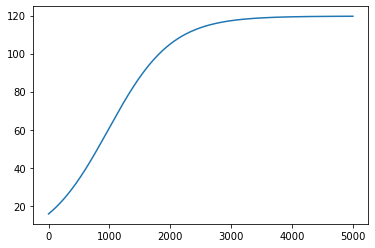

In [52]:
plt.plot(xvalues, logistic(xvalues, popt[0], popt[1], popt[2]))

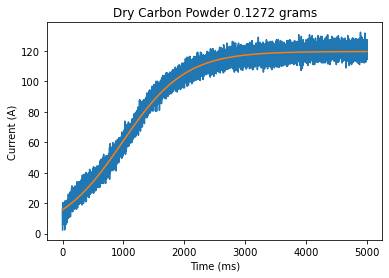

In [53]:
data.plot('Time', 'Current', legend = None)
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.title("Dry Carbon Powder 0.1272 grams")
plt.plot(xvalues, logistic(xvalues, popt[0], popt[1], popt[2]))
plt.show()

In [78]:
value = (remonsum(data, "Time", "Current"))/1000

In [79]:
print(value)

472.66252922096163


In [382]:
def splitnav(oglist, size):
    listlist = []
    avlist = []
    length = len(oglist)
    count = 0
    number_of_groups = int(len(oglist)/size)

    for i in range(number_of_groups):
        templist = []
        running = 0
        for i in range(size):
            templist.append(oglist[count])
            running += oglist[count]
            count += 1
        avlist.append(running/size)
        listlist.append(templist)
     
    return listlist, avlist, number_of_groups

def change_of_av(dataframe, column, size):
    interumframe = pd.DataFrame()
    groups, interumframe['Average values'],  number_of_groups= splitnav(dataframe[column], size)
    interumframe['shifted'] = interumframe['Average values'].shift(periods = 1)
    delta = (np.subtract(interumframe['Average values'], interumframe['shifted']))
    
    return interumframe, delta, groups


def findmiddlevalue(dataframe, column, size):
    listlist, avlist, number_of_groups = splitnav(dataframe[column], size)
    #check if number is even or odd if odd simply gives middle value if even takes average of two values
    if (size%2 != 0):
        middle_values = []
        for i in listlist:
            middle_values.append(i[int(size/2 - .5)])
        return middle_values
    else:
        middle_values = []
        for i in listlist:
            index2 = int(size/2)
            index1 = int(index2 -1)
            value = (i[index1] + i[index2])/2
            middle_values.append(value)
        return middle_values
        

In [268]:
fiveaverage = pd.DataFrame()
fiveaverage['Time'] = findmiddlevalue(data, 'Time', 10)
listolist, fiveaverage['Average'], numberogroups = splitnav(data['Current'], 10)
fiveaverage['rolling'] = data['Current'].rolling(10).mean()
fiveaverage['rollingshifted'] = fiveaverage['rolling'].shift(periods = 1, fill_value = 0)
fiveaverage['rollingdiff'] = np.divide(np.subtract(fiveaverage['rolling'],fiveaverage['rollingshifted']), fiveaverage['rolling'])

<AxesSubplot:xlabel='Time'>

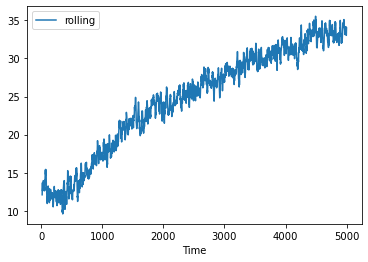

In [269]:
fiveaverage.plot('Time','rolling')

<AxesSubplot:xlabel='Time'>

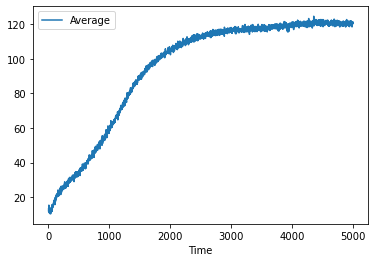

In [270]:
fiveaverage['Averageshifted'] = fiveaverage['Average'].shift(periods = 1, fill_value = 0)
fiveaverage['Averagediff'] = np.subtract(fiveaverage['Average'], fiveaverage['Averageshifted'])


fiveaverage.plot('Time', 'Average')

<AxesSubplot:xlabel='x'>

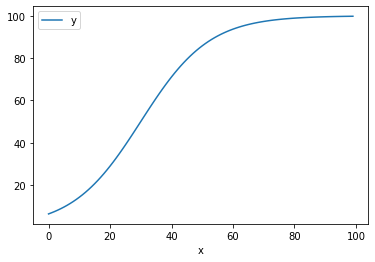

In [384]:
testframe = pd.DataFrame()
testframe['x'] = np.arange(0, 100, 1) 
testframe['y'] = logistic(testframe['x'], 30, .09,100)
testframe.plot('x', 'y')

In [389]:
pd.set_option('display.max_rows', 1000)
testframe['rolling'] = testframe['y'].rolling(20).mean()
midavframe = pd.DataFrame()
listlist, midavframe['y'], number_of_groups = splitnav(testframe['y'], 5)
midavframe['x'] = findmiddlevalue(testframe, 'x', 5)

<AxesSubplot:xlabel='x'>

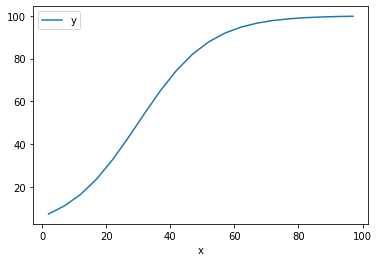

In [390]:
midavframe.plot('x', 'y')

In [366]:
testframe['rollingshifted'] = testframe['rolling'].shift(periods = 1)
testframe['rolldiff'] = (testframe['rolling'] - testframe['rollingshifted'])/testframe['rolling']

In [459]:
midavframe['yshift'] = midavframe['y'].shift(periods =1)
midavframe['ydiff'] = (midavframe['y'] - midavframe['yshift'])

<AxesSubplot:xlabel='x'>

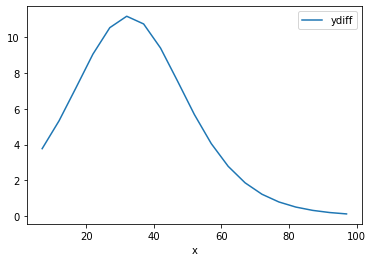

In [460]:
midavframe.plot('x', 'ydiff')

In [455]:
data['rolling'] = data['Current'].rolling(8000).mean()
data['rollshift'] = data['rolling'].shift(periods = 1)
data['rolldiff'] = (data['rolling'] - data['rollshift'])


<AxesSubplot:xlabel='Time'>

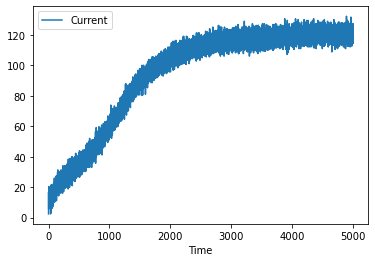

In [491]:
#data.plot('Time', 'Current')
data.plot('Time', 'Current')

In [473]:
datamidavframe = pd.DataFrame()
listlist, datamidavframe['Current'], number_of_groups = splitnav(data['Current'], 1000)
datamidavframe['Time'] = findmiddlevalue(data, 'Time', 1000)
datamidavframe['curshift'] = datamidavframe['Current'].shift(periods = 1)
datamidavframe['diff'] = (datamidavframe['Current'] - datamidavframe['curshift'])

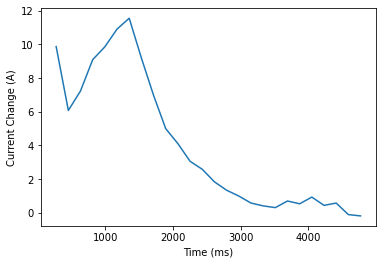

In [557]:
datamidavframe.plot("Time", "diff", legend = False, xlabel = 'Time (ms)', ylabel = 'Current Change (A)')

plt.show()

array([0.        , 0.69314718, 1.09861229, 1.38629436, 1.60943791,
       1.79175947, 1.94591015, 2.07944154, 2.19722458, 2.30258509])

In [502]:
index = 0
comparevalue = datamidavframe['diff'][1]
for i in range(2, len(datamidavframe['diff'])):
    if comparevalue < datamidavframe['diff'][i]:
        comparevalue = datamidavframe['diff'][i]
        index = i
    
    

In [504]:
index
datamidavframe['Time'][index]

1350.969

In [542]:
remanframe = pd.DataFrame()
timestop = datamidavframe['Time'][index] * 2
index2 = 0
i = 0
for i in range(1, len(data['Time'])):
    if data['Time'][i] <= timestop:
               index2 = i
               

               
               

In [543]:
print(index2)
data['Time'][index2]

14999


2701.918

In [546]:
remanframe['Time'] = data['Time'][:(index2+1):]
remanframe['Current'] = data['Current'][:(index2+1):]

In [549]:
print( (remonsum(remanframe, 'Time', 'Current')/ 1000) *8)

1598.1856571914027


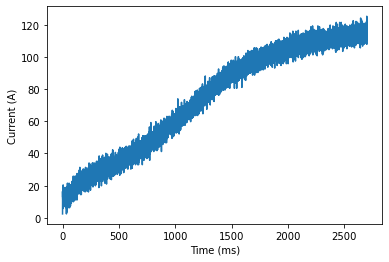

In [558]:
remanframe.plot('Time', 'Current', legend = False, xlabel = "Time (ms)", ylabel = 'Current (A)')
plt.show()

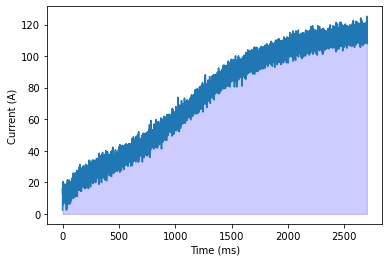

In [561]:
remanframe.plot('Time', 'Current', legend = False, xlabel = "Time (ms)", ylabel = 'Current (A)')
plt.fill_between(remanframe['Time'], remanframe['Current'], color = 'b', alpha = .2)
plt.show()

In [489]:
data2 = pd.read_csv("/Users/christiannorman/Documents/Crus Center/Scholar/FJH/data/FirstFlash", skiprows = 3)
data2midavframe = pd.DataFrame()
listlist, data2midavframe['Current'], number_of_groups = splitnav(data2['Current'], 25)
data2midavframe['Time'] = findmiddlevalue(data2, 'Time', 25)
data2midavframe['curshift'] = data2midavframe['Current'].shift(periods = 1)
data2midavframe['diff'] = (data2midavframe['Current'] - data2midavframe['curshift'])

<AxesSubplot:xlabel='Time'>

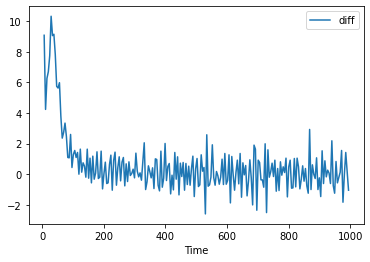

In [490]:
data2midavframe.plot('Time', 'diff')

<AxesSubplot:xlabel='Time'>

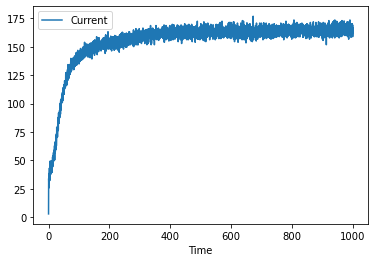

In [484]:
data2.plot('Time', 'Current')